# FCC Magic Gamma Telescope

This report is a supervise machine learning project that aims to predict the classification of gamma and hadron particles based on the features provided in the dataset. The dataset contains 10 features and a target variable. The target variable is binary, with `g` representing gamma particles and `h` representing hadron particles.

## Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

2024-08-01 03:10:52.574807: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Supress warning configurations

- TensorFlow logging
- Specific `FutureWarning`s

In [2]:
# TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data preprocessing

- Dataset URL: https://raw.githubusercontent.com/cogxen/datasets/main/fcc-magic/magic_04.data
- Rename the columns, use the following:
    - [`fLegLength`, `fWidth`, `fSize`, `fConc`, `fConc1`, `fAsym`, `fM3Long`, `fM3Trans`, `fAlpha`, `fDist`, `class`]
- Display th first 5 rows

In [3]:
dataset_url = "https://raw.githubusercontent.com/cogxen/datasets/main/fcc-magic/magic_04.data"
cols = ["fLegLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist", "class"]
df = pd.read_csv(dataset_url, names=cols)
df.head()

,fLegLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


- Data Cleaning
    - Change the `class` cloumm to binary values
    - Then display the dataframe, again

In [4]:
df["class"] = df["class"].map({"g": 1, "h": 0})
df.head()

,fLegLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1


## Visualization
   
- Plot the dataframe using `hist` or histograms

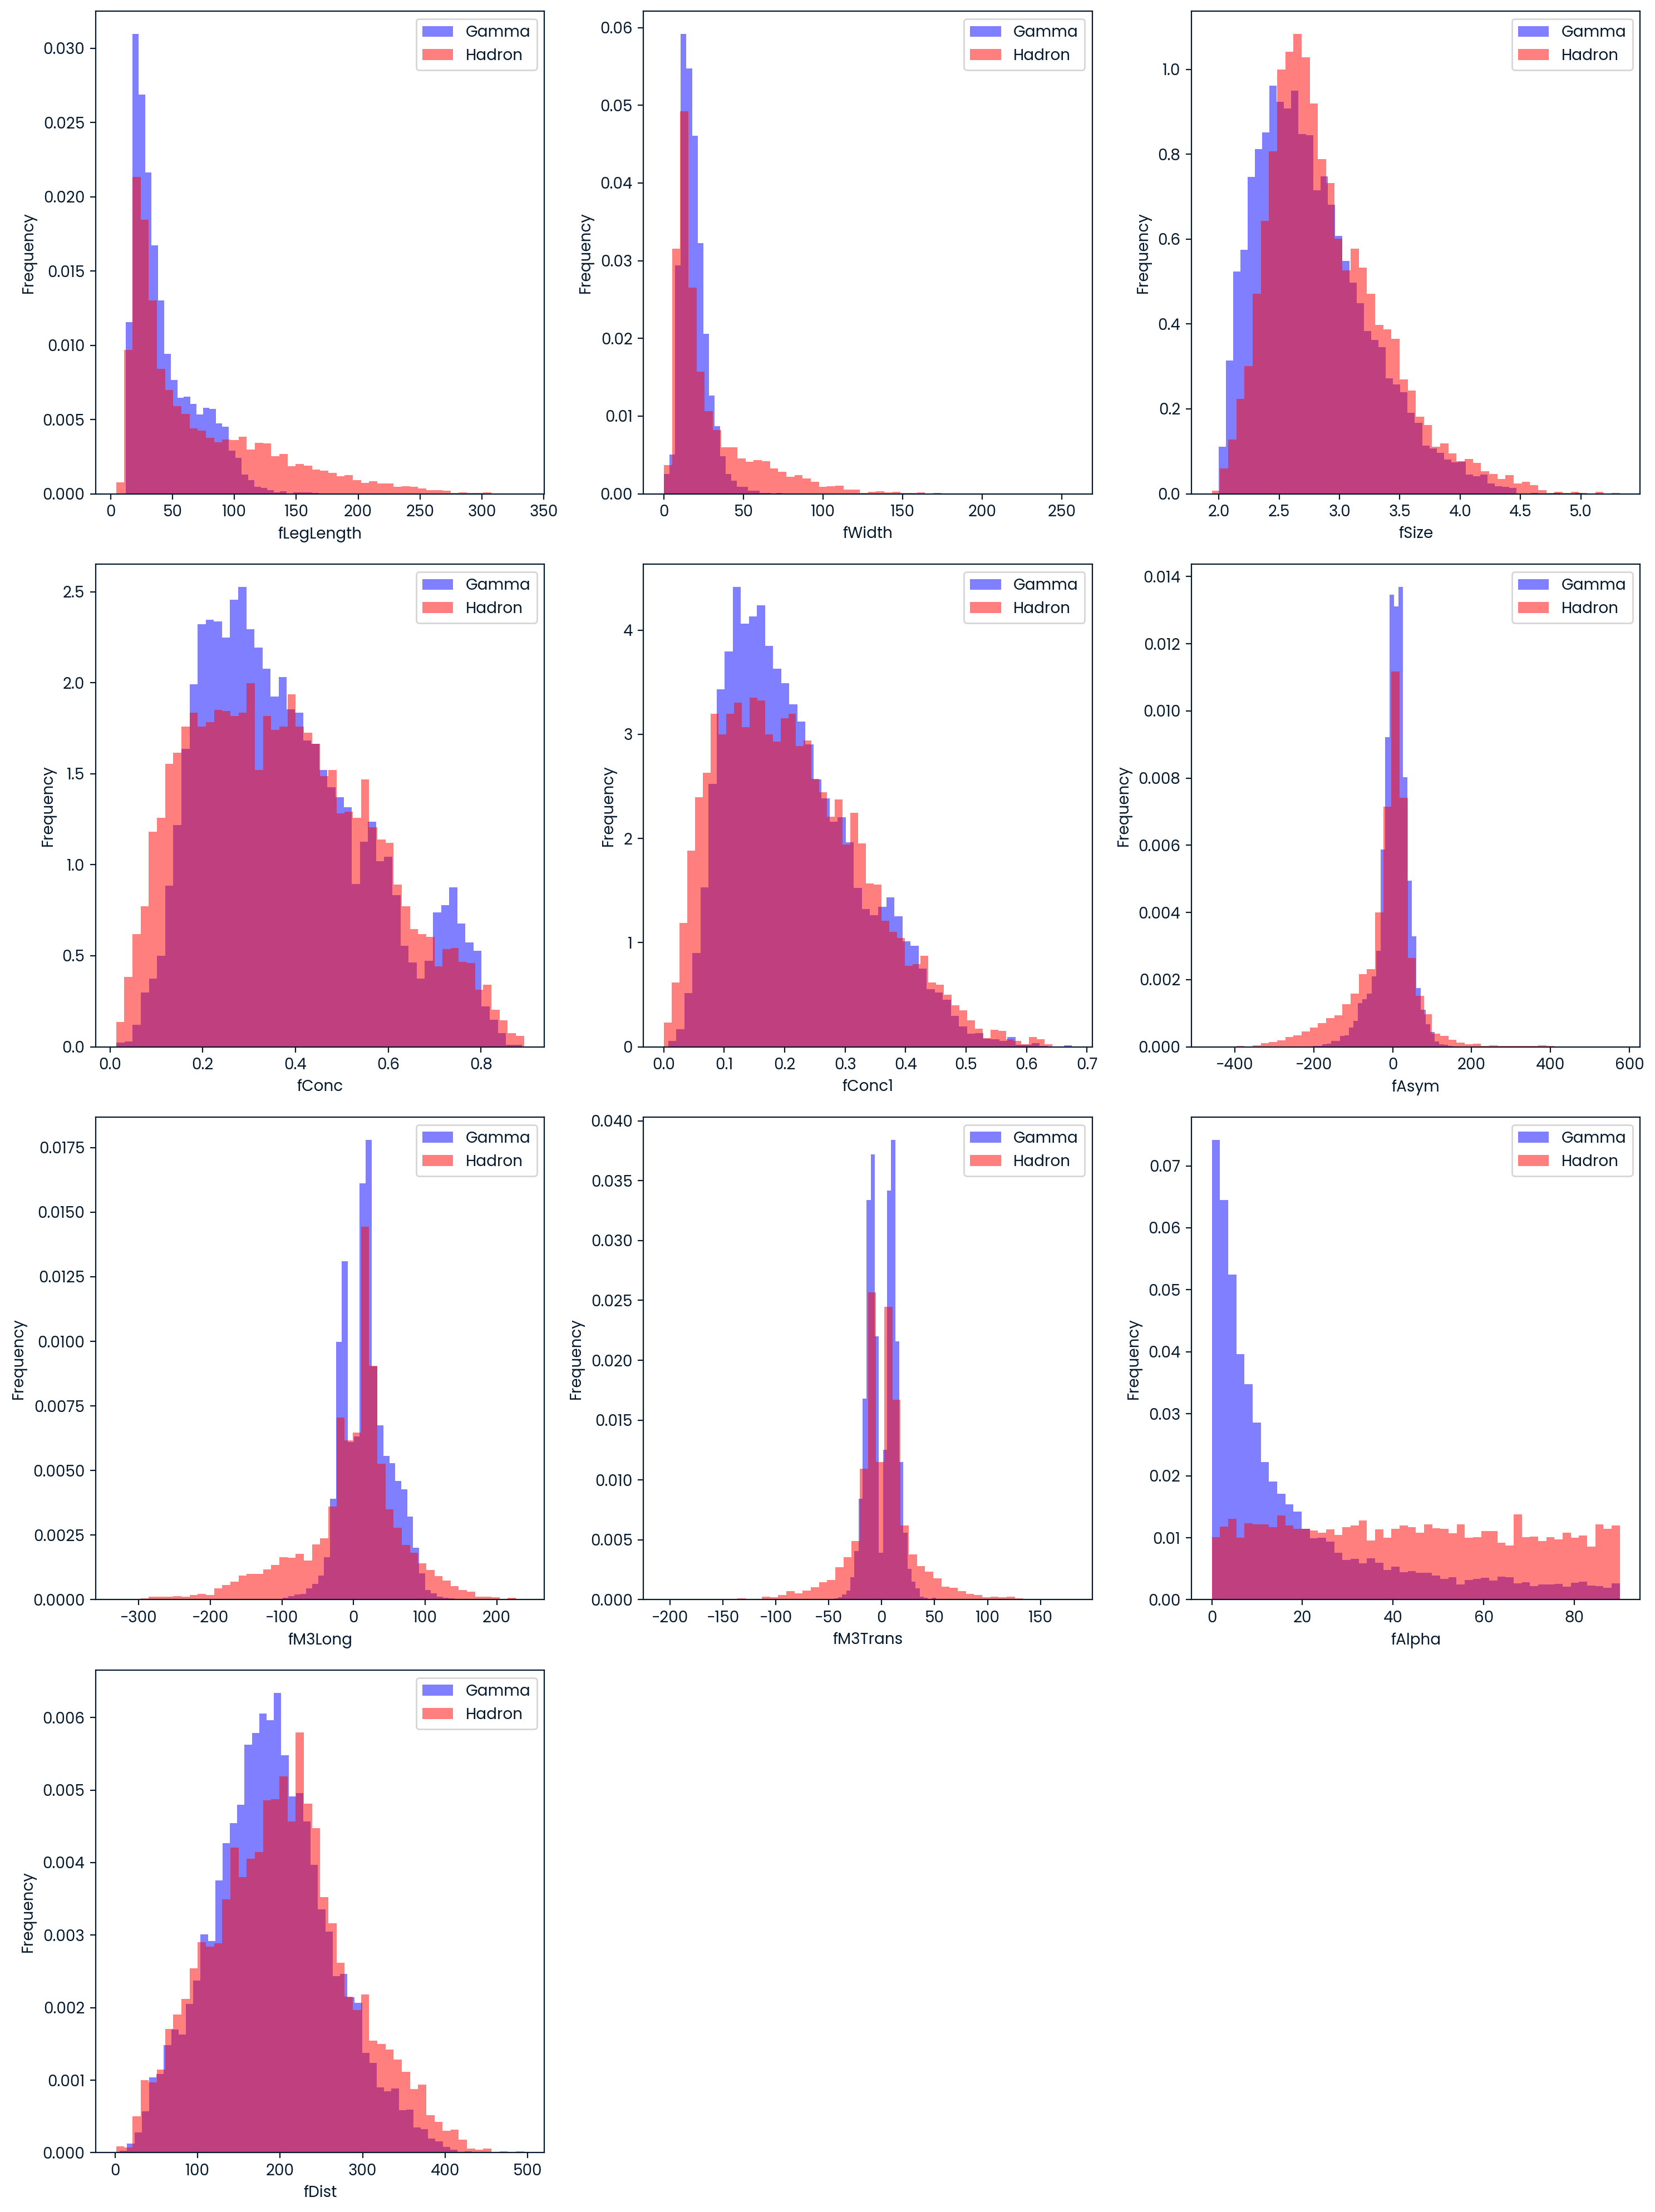

In [5]:
# Plot the data using histograms
num_cols = len(df.columns[:-1])
num_rows = (num_cols + 2) // 3  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for i, label in enumerate(df.columns[:-1]):
    axes[i].hist(df[df["class"] == 1][label], bins=50, alpha=0.5, label="Gamma", color="blue", density=True)
    axes[i].hist(df[df["class"] == 0][label], bins=50, alpha=0.5, label="Hadron", color="red", density=True)
    axes[i].set_xlabel(label)
    axes[i].set_ylabel("Frequency")
    axes[i].legend()

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Generate `train`, `validate`, and `test` datasets

In [6]:
train, validate, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

- Create a function that standardize its features
    - Optional, add oversampling - the minority class

In [7]:
def scale_data(dataframe, over_sample=False):
    x = dataframe[dataframe.columns[:-1]].values
    y = dataframe[dataframe.columns[-1]].values
    
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    
    if over_sample:
        ros = RandomOverSampler(sampling_strategy="minority")
        x, y = ros.fit_resample(x, y)
    
    data = np.hstack((x, np.reshape(y, (-1, 1))))
    
    return data, x, y

- Apply the `scale_data` function and processed the feature standardization and oversampling on `train` DataFrame to balance the dataset.
- Same on `validate` and `test` but only feature standardization, without any oversampling.

##### This separation ensures that the model is trained on a balanced dataset but evaluated on datasets that reflect the real-world distribution of classes, avoiding data leakage and ensuring a fair evaluation.

In [8]:
train, x_train, y_train = scale_data(train, over_sample=True)
validate, x_validate, y_validate = scale_data(validate, over_sample=False)
test, x_test, y_test = scale_data(test, over_sample=False)

## Classification Models

- K-Nearest Neighbors Classifier
- Naive Bayes Classifier
- Logistic Regression
- Support Vector Machine (SVM)
- Neural Network

### K-Nearest Neighbors Classifier

In [9]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [10]:
y_pred = knn.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.70      0.72      1302
           1       0.85      0.88      0.86      2502

    accuracy                           0.82      3804
   macro avg       0.80      0.79      0.79      3804
weighted avg       0.82      0.82      0.82      3804



### Naive Bayes Classifier

In [11]:
nb = GaussianNB()
nb.fit(x_train, y_train)

GaussianNB()

In [12]:
y_pred = nb.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.40      0.50      1302
           1       0.74      0.90      0.81      2502

    accuracy                           0.73      3804
   macro avg       0.71      0.65      0.66      3804
weighted avg       0.72      0.73      0.71      3804



### Logistic Regression

In [13]:
lg = LogisticRegression()
lg.fit(x_train, y_train)

LogisticRegression()

In [14]:
y_pred = lg.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.73      0.70      1302
           1       0.85      0.82      0.84      2502

    accuracy                           0.79      3804
   macro avg       0.77      0.78      0.77      3804
weighted avg       0.79      0.79      0.79      3804



### Support Vector Machine (SVM)

In [15]:
svm = SVC()
svm.fit(x_train, y_train)

SVC()

In [16]:
y_pred = svm.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1302
           1       0.90      0.89      0.89      2502

    accuracy                           0.86      3804
   macro avg       0.84      0.85      0.85      3804
weighted avg       0.86      0.86      0.86      3804



### Neural Network

In [24]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Binary Crossentropy')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [19]:
nn = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(10, )),
    tf.keras.layers.Dense(32, activation='relu', input_shape=(10, )),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

nn.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

- Train the model

In [22]:
history = nn.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8900 - loss: 0.2581 - val_accuracy: 0.8319 - val_loss: 0.3334
Epoch 2/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - accuracy: 0.8936 - loss: 0.2483 - val_accuracy: 0.8095 - val_loss: 0.3793
Epoch 3/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.8993 - loss: 0.2469 - val_accuracy: 0.8377 - val_loss: 0.3272
Epoch 4/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8974 - loss: 0.2466 - val_accuracy: 0.8340 - val_loss: 0.3322
Epoch 5/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - accuracy: 0.8991 - loss: 0.2463 - val_accuracy: 0.7945 - val_loss: 0.4184
Epoch 6/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - accuracy: 0.8975 - loss: 0.2460 - val_accuracy: 0.8132 - val_loss: 0.3714
Epoch 7/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - accuracy: 0.8942 - loss: 0.2468 - val_accuracy: 0.8316 - val_loss: 0.3331
Epoch 8/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.9019 - loss: 0.242

- Plot the loss, if any

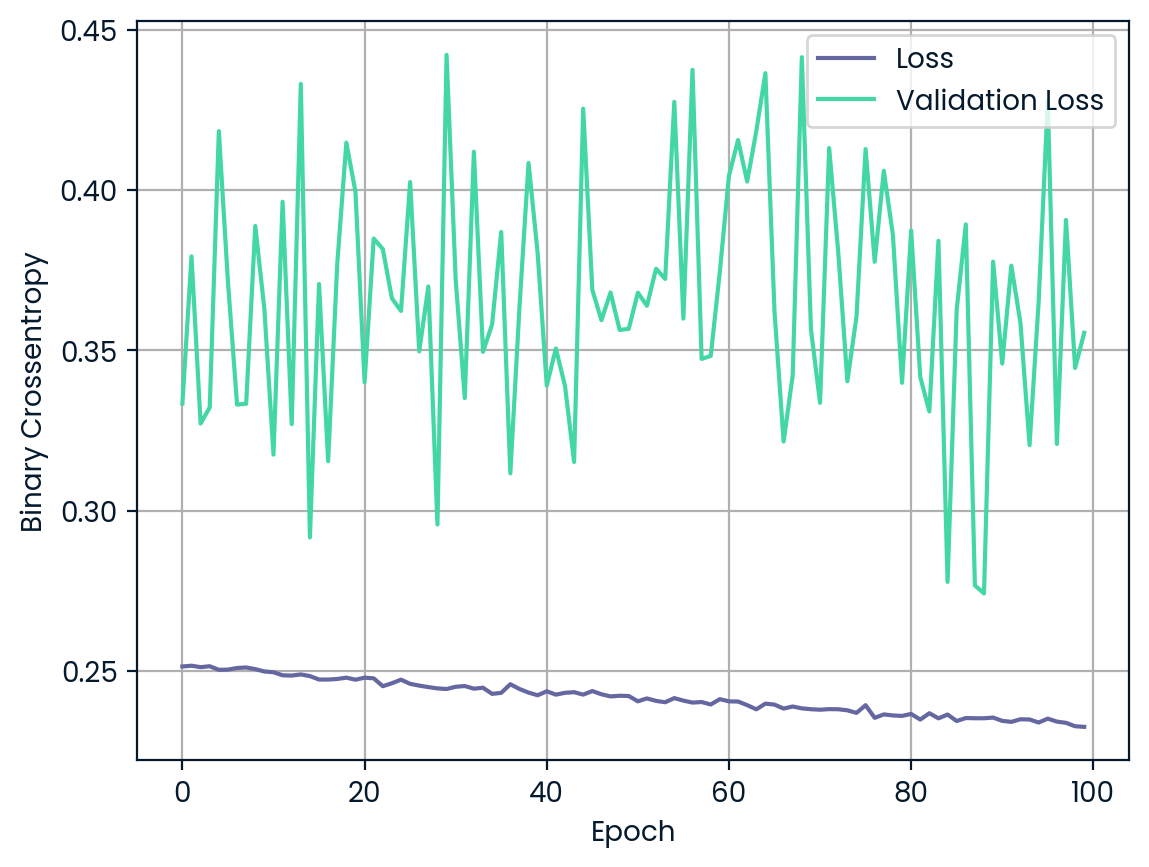

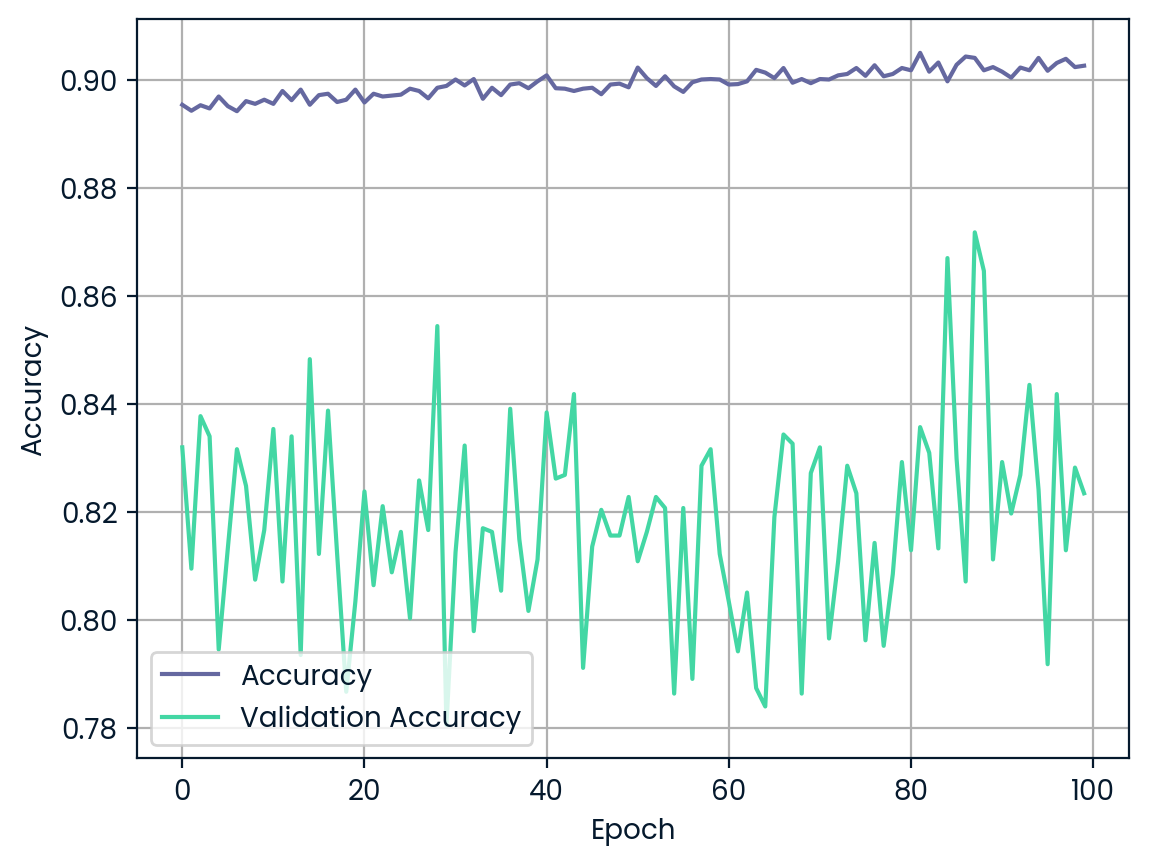

In [25]:
plot_loss(history)
plot_accuracy(history)